In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import cv2
import io
import decord
from inference import unet3d_Inference, unet2dshift_Inference
pj = os.path.join

In [2]:
def enhance_contrast(img,gamma=0.8):
    fimg = img.astype(np.float32)/255
    fimg = fimg**gamma
    fimg = (fimg*255).astype(np.uint8)
    return fimg

def enhance_gray(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,-1].copy()
    v = cv2.equalizeHist(v)
    hsv[:,:,-1] = v
    img = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return img

def enhance_gray_bgr(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    v = hsv[:,:,-1].copy()
    v = cv2.equalizeHist(v)
    hsv[:,:,-1] = v
    img = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    return img

In [4]:
import shutil
# vid_file = '/project/data/google/tv05.mp4'
# save_path = '/project/data/google/tv05_mp4/'
vid_file = '/project/data/google/huawei_gkpw/huawei_gkpw_no_box.mp4'
save_path = '/project/data/google/huawei_gkpw/'
# shutil.rmtree(save_path, ignore_errors=True)
# os.makedirs(save_path, exist_ok=True)

container = decord.VideoReader(vid_file, num_threads=1)
total_frames = len(container)
T = 3

# model = unet3d_Inference(ckpt_path='./pth/', use_cuda=True)
model = unet2dshift_Inference(ckpt_path='./pth/UNet2DShift/', use_cuda=True)


vid_fps = 28
H,W = 640,640
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
filename = os.path.basename(vid_file).replace('.','_3dunet.')
vid = cv2.VideoWriter( pj(save_path,'{}.mp4'.format(filename)),fourcc,vid_fps,(2*W,H))

#h,w = 1080,1440
x1,x2 = [100,520]
y1,y2 = [300,780]

for frameid in range(20,total_frames-T):
    print('{:.1f}%'.format(frameid/total_frames*100),end='\r')
    frame_set = list(range(frameid,frameid+T))
    imgs = [ container[i].asnumpy()[y1:y2,x1:x2] for i in frame_set ] #rgb
#     imgs = [ container[i].asnumpy() for i in frame_set ] #rgb
    imgs = [ enhance_gray(im) for im in imgs ]
    imgs = [ cv2.cvtColor(im,cv2.COLOR_RGB2BGR) for im in imgs ]
    imgs = [ cv2.resize(im, (W,H)) for im in imgs ]
    mask = model.inference(imgs)
    mask = (mask > 0.2).astype(np.uint8)
    mask *= 255
#     img_masked = np.stack([mask]*3,axis=2)
    
    kernel = np.ones((3, 3), dtype=np.uint8)
    dilate_mask = cv2.dilate(mask, kernel, 5) # 更改迭代次数为2
    roi = mask > 20
    roic = mask <= 20
    
    img = imgs[-1]
#     print(img_masked.shape,img.shape)
    img_masked = img.copy()
    img_masked = img_masked.astype(np.float32)
    img_masked[roic] *= 0.5
    img_masked[roi] = 255
    img_masked = img_masked.astype(np.uint8)
    
    img = np.concatenate([img,img_masked],axis=1)
    vid.write(img)
    
#     cv2.imwrite(pj(save_path,'frame_{:04d}.jpg'.format(frameid)), img)
del container
vid.release()

=> Using fold div: 3
=> Using fold div: 3
=> Using fold div: 3
=> Using fold div: 3
=> Using fold div: 3
=> Using fold div: 3
Found ./pth/UNet2DShift/model_183.pth
loading from ./pth/UNet2DShift/model_183.pth


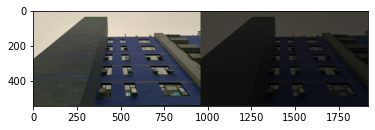

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [19]:
import shutil
vid_file = '/project/data/google/tv05.mp4'
save_path = '/project/data/google/gkpw/tv05_eq/'
if os.path.exists(save_path):
    shutil.rmtree(save_path, ignore_errors=True)
os.makedirs(save_path, exist_ok=True)
# shutil.rmtree(save_path, ignore_errors=True)
# os.makedirs(save_path, exist_ok=True)

container = decord.VideoReader(vid_file, num_threads=1)
total_frames = len(container)
print('total {:d} frames'.format(total_frames))
T = 3
step = 1

for frameid in range(20,total_frames-T,step):
    print('{:.1f}%'.format(frameid/total_frames*100),end='\r')
    img = container[frameid].asnumpy()
    img = enhance_gray(img)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    filename = '{:04d}.png'.format(frameid)
    filename = pj(save_path, filename)
    cv2.imwrite(filename, img)
    

total 165 frames
